In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

khadiza13_meme_ds_path = kagglehub.dataset_download('khadiza13/meme-ds')

print('Data source import complete.')


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import clip
from PIL import Image
import random
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from torch.cuda import amp
from tqdm import tqdm
from collections import defaultdict
import gc
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-ys3a4i6x
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-ys3a4i6x
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done


In [ ]:
def set_random_seed(random_seed):
    random.seed(random_seed)
    np.random.seed(random_seed)
    os.environ["PYTHONHASHSEED"] = str(random_seed)
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)
    torch.backends.cudnn.deterministic = True


In [ ]:
class Config:
    NUM_EPOCHS = 15
    BATCH_SIZE = 16  # Reduced for CLIP
    CLIP_MODEL = "ViT-L/14"  # Using ViT-L/14 as mentioned
    LR = 2e-4
    DROPOUT = 0.2
    NUM_CLASSES = 3
    SEED = 42
    MAX_LEN = 77  # CLIP's max sequence length
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    LSTM_HIDDEN = 256
    FC_HIDDEN = 256
    TEXT_EMBED_DIM = 768  # CLIP text embedding dimension
    IMAGE_EMBED_DIM = 768  # CLIP image embedding dimension

config = Config()


In [ ]:
df = pd.read_csv("/kaggle/input/meme-ds/changed_ds/dataset_with_class.csv")
df.columns = ['image_name', 'Text', 'label']
df.head(10)

,image_name,Text,label
0,2001.jpg,আচ্ছা ভাই।\n মেয়েদের থেকে দূরে থাকবা মেয়ের পাল...,non-misogynistic
1,2002.jpg,কিসের foodpanda যেখানে আমার সাদিয়া রে অর্ডার ক...,stereotype & objectification
2,2003.jpg,উপস্থিত sir\n Yes sir\n Present Teacher\n [লাব...,stereotype & objectification
3,2004.png,আমি হিজাব চাইনি\n তারপর আমার স্বামী আমাকে বোঝালেন,violence or abuse
4,2005.jpg,"বাঙ্গু (beta, omega, theta, delta) male\nসুন্দ...",non-misogynistic
5,2006.jpg,"বাবু, আমি তোমার হাত ঘড়ি হতে চাই।\nকারণ? \nযাতে...",non-misogynistic
6,2007.jpg,গর্ত খুঁড়ে ফেললাম কারণ এক আপু পোস্ট করেছে গর্ত...,non-misogynistic
7,2008.jpg,"কেউ পাত্তা দিচ্ছে না, ভিউ, ফলোয়ার, রিচ নাই?\nল...",stereotype & objectification
8,2009.jpg,ভুনা খিচুড়ি আমি শীতকাল,non-misogynistic
9,2010.jpg,me The movie\nsubtitles,stereotype & objectification


In [ ]:
le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])

# Print class distribution
print("Class distribution:")
print(df['label'].value_counts().sort_index())
print(df.sample(5))

Class distribution:
label
0    1464
1    1830
2    1006
Name: count, dtype: int64
      image_name                                               Text  label
1943    3660.jpg  চাইতেই পারো আমার ঘাড়ে পা রেখে আকাশটা ছোঁয়ার স্...      1
2518     977.jpg  Nayeem Junior \r\nRayhan Kobir Rohan শুধু Rape...      2
2738  in 185.jpg  দিদি ওদিকের খবর কী? তুই চাপ নিস না; কয়লা; বালি...      0
761     2478.jpg  এক 16 বছরের ছেলে\nএকটি বৌদি কে সেক্স করার অফার...      1
3731     349.png  আপনি যখন 2 দিনের জন্য সম্পর্কের মধ্যে থাকেন এব...      2


In [ ]:
# Calculate class weights for handling imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(df['label']), y=df['label'])
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}
print(f"Class weights: {class_weights_dict}")

Class weights: {0: 0.9790528233151184, 1: 0.7832422586520947, 2: 1.4247846255798542}


In [ ]:
# Split data
X = df[['image_name', 'Text']].values
y = df['label'].values

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

# Create DataFrames
train_df = pd.DataFrame(X_train, columns=['image_name', 'Text'])
train_df['label'] = y_train

val_df = pd.DataFrame(X_val, columns=['image_name', 'Text'])
val_df['label'] = y_val

test_df = pd.DataFrame(X_test, columns=['image_name', 'Text'])
test_df['label'] = y_test

print(f"Train samples: {len(train_df)}, Val samples: {len(val_df)}, Test samples: {len(test_df)}")


Train samples: 3010, Val samples: 645, Test samples: 645


In [ ]:
class CLIPMultimodalDataset(Dataset):
    def __init__(self, df, clip_model, clip_preprocess, is_train=True):
        self.df = df.reset_index(drop=True)
        self.clip_model = clip_model
        self.clip_preprocess = clip_preprocess
        self.is_train = is_train
        self.labels = torch.tensor(df['label'].values, dtype=torch.long)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # Load and preprocess image
        image_path = f"/kaggle/input/meme-ds/changed_ds/img/{row['image_name']}"
        try:
            image = Image.open(image_path).convert('RGB')
            image_input = self.clip_preprocess(image)
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            # Create a dummy image if loading fails
            image_input = torch.zeros((3, 224, 224))

        # Process text
        text = str(row['Text'])
        text_tokens = clip.tokenize(text, truncate=True).squeeze(0)

        label = self.labels[idx]

        return {
            'image': image_input,
            'text_tokens': text_tokens,
            'label': label
        }


In [ ]:
class CLIPBasedMultimodalModel(nn.Module):
    def __init__(self, clip_model, num_classes, lstm_hidden=256, fc_hidden=256, dropout=0.2):
        super(CLIPBasedMultimodalModel, self).__init__()

        # CLIP encoders (frozen)
        self.clip_model = clip_model
        for param in self.clip_model.parameters():
            param.requires_grad = False

        # Text processing components
        self.text_lstm = nn.LSTM(
            input_size=config.TEXT_EMBED_DIM,
            hidden_size=lstm_hidden,
            batch_first=True,
            bidirectional=False
        )

        # Image processing components
        self.image_fc = nn.Linear(config.IMAGE_EMBED_DIM, fc_hidden)

        # Dropout layers
        self.text_dropout = nn.Dropout(dropout)
        self.image_dropout = nn.Dropout(dropout)

        # Final fusion layer
        self.fusion_fc = nn.Sequential(
            nn.Linear(lstm_hidden + fc_hidden, fc_hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(fc_hidden, num_classes)
        )

    def forward(self, image, text_tokens):
        batch_size = image.shape[0]

        # Extract CLIP features
        with torch.no_grad():
            # Get image features
            image_features = self.clip_model.encode_image(image).float()

            # Get text features - we need token-level features for LSTM
            # This is a bit tricky with CLIP, so we'll use the final text features
            text_features = self.clip_model.encode_text(text_tokens).float()

        # Process image features
        image_out = self.image_fc(image_features)
        image_out = self.image_dropout(image_out)

        # For text, we'll expand the features to simulate token-level processing
        # In a real implementation, you'd need access to intermediate representations
        text_expanded = text_features.unsqueeze(1).repeat(1, 10, 1)  # Simulate sequence
        lstm_out, (hidden, _) = self.text_lstm(text_expanded)
        text_out = hidden[-1]  # Take last hidden state
        text_out = self.text_dropout(text_out)

        # Concatenate and fuse
        combined = torch.cat([text_out, image_out], dim=1)
        output = self.fusion_fc(combined)

        return output


In [ ]:
class WeightedCrossEntropyLoss(nn.Module):
    def __init__(self, class_weights):
        super(WeightedCrossEntropyLoss, self).__init__()
        self.class_weights = torch.FloatTensor(class_weights).to(config.DEVICE)

    def forward(self, outputs, targets):
        return F.cross_entropy(outputs, targets, weight=self.class_weights)

def create_weighted_sampler(labels):
    """Create weighted sampler to handle class imbalance"""
    class_counts = np.bincount(labels)
    class_weights = 1.0 / class_counts
    sample_weights = class_weights[labels]
    sampler = WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        replacement=True
    )
    return sampler

def compute_metrics(y_true, y_pred):
    """Compute various metrics"""
    accuracy = accuracy_score(y_true, y_pred)
    f1_weighted = f1_score(y_true, y_pred, average='weighted')
    f1_macro = f1_score(y_true, y_pred, average='macro')

    return {
        'accuracy': accuracy,
        'f1_weighted': f1_weighted,
        'f1_macro': f1_macro
    }


In [ ]:
class ImprovedEngine:
    def __init__(self, model, optimizer, criterion, scheduler=None):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.scheduler = scheduler

    def train_epoch(self, train_loader, scaler):
        self.model.train()
        total_loss = 0
        all_preds = []
        all_labels = []

        progress_bar = tqdm(train_loader, desc="Training")

        for batch in progress_bar:
            images = batch['image'].to(config.DEVICE)
            text_tokens = batch['text_tokens'].to(config.DEVICE)
            labels = batch['label'].to(config.DEVICE)

            self.optimizer.zero_grad()

            with amp.autocast():
                outputs = self.model(images, text_tokens)
                loss = self.criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(self.optimizer)
            scaler.update()

            if self.scheduler:
                self.scheduler.step()

            total_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})

        avg_loss = total_loss / len(train_loader)
        metrics = compute_metrics(all_labels, all_preds)

        return avg_loss, metrics

    def evaluate(self, eval_loader):
        self.model.eval()
        total_loss = 0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for batch in tqdm(eval_loader, desc="Evaluating"):
                images = batch['image'].to(config.DEVICE)
                text_tokens = batch['text_tokens'].to(config.DEVICE)
                labels = batch['label'].to(config.DEVICE)

                outputs = self.model(images, text_tokens)
                loss = self.criterion(outputs, labels)

                total_loss += loss.item()

                preds = torch.argmax(outputs, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        avg_loss = total_loss / len(eval_loader)
        metrics = compute_metrics(all_labels, all_preds)

        return avg_loss, metrics, all_preds, all_labels


In [ ]:
def plot_training_history(history):
    """Plot training and validation metrics"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Loss
    axes[0, 0].plot(history['train_loss'], label='Train Loss')
    axes[0, 0].plot(history['val_loss'], label='Val Loss')
    axes[0, 0].set_title('Loss')
    axes[0, 0].legend()

    # Accuracy
    axes[0, 1].plot(history['train_acc'], label='Train Acc')
    axes[0, 1].plot(history['val_acc'], label='Val Acc')
    axes[0, 1].set_title('Accuracy')
    axes[0, 1].legend()

    # F1 Weighted
    axes[1, 0].plot(history['train_f1_weighted'], label='Train F1 Weighted')
    axes[1, 0].plot(history['val_f1_weighted'], label='Val F1 Weighted')
    axes[1, 0].set_title('F1 Score (Weighted)')
    axes[1, 0].legend()

    # F1 Macro
    axes[1, 1].plot(history['train_f1_macro'], label='Train F1 Macro')
    axes[1, 1].plot(history['val_f1_macro'], label='Val F1 Macro')
    axes[1, 1].set_title('F1 Score (Macro)')
    axes[1, 1].legend()

    plt.tight_layout()
    plt.show()


In [ ]:
def run_training():
    set_random_seed(config.SEED)

    # Load CLIP model
    print("Loading CLIP model...")
    clip_model, clip_preprocess = clip.load(config.CLIP_MODEL, device=config.DEVICE)

    # Create datasets
    train_dataset = CLIPMultimodalDataset(train_df, clip_model, clip_preprocess, is_train=True)
    val_dataset = CLIPMultimodalDataset(val_df, clip_model, clip_preprocess, is_train=False)
    test_dataset = CLIPMultimodalDataset(test_df, clip_model, clip_preprocess, is_train=False)

    # Create weighted sampler for training
    train_sampler = create_weighted_sampler(train_df['label'].values)

    # Create data loaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=config.BATCH_SIZE,
        sampler=train_sampler,
        num_workers=2
    )
    val_loader = DataLoader(val_dataset, batch_size=config.BATCH_SIZE, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=config.BATCH_SIZE, shuffle=False, num_workers=2)

    # Create model
    model = CLIPBasedMultimodalModel(
        clip_model=clip_model,
        num_classes=config.NUM_CLASSES,
        lstm_hidden=config.LSTM_HIDDEN,
        fc_hidden=config.FC_HIDDEN,
        dropout=config.DROPOUT
    ).to(config.DEVICE)

    # Create optimizer and criterion
    optimizer = torch.optim.AdamW(
        [p for p in model.parameters() if p.requires_grad],
        lr=config.LR,
        weight_decay=0.01
    )

    # Use weighted loss
    criterion = WeightedCrossEntropyLoss(list(class_weights_dict.values()))

    # Create scheduler
    num_training_steps = config.NUM_EPOCHS * len(train_loader)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_training_steps)

    # Create engine
    engine = ImprovedEngine(model, optimizer, criterion, scheduler)
    scaler = amp.GradScaler()

    # Training loop
    history = defaultdict(list)
    best_val_f1 = 0.0
    patience = 5
    patience_counter = 0

    print("Starting training...")
    for epoch in range(config.NUM_EPOCHS):
        print(f"\nEpoch {epoch + 1}/{config.NUM_EPOCHS}")

        # Train
        train_loss, train_metrics = engine.train_epoch(train_loader, scaler)

        # Validate
        val_loss, val_metrics, _, _ = engine.evaluate(val_loader)

        # Log metrics
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_metrics['accuracy'])
        history['val_acc'].append(val_metrics['accuracy'])
        history['train_f1_weighted'].append(train_metrics['f1_weighted'])
        history['val_f1_weighted'].append(val_metrics['f1_weighted'])
        history['train_f1_macro'].append(train_metrics['f1_macro'])
        history['val_f1_macro'].append(val_metrics['f1_macro'])

        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_metrics['accuracy']:.4f}, Train F1: {train_metrics['f1_weighted']:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_metrics['accuracy']:.4f}, Val F1: {val_metrics['f1_weighted']:.4f}")

        # Early stopping
        if val_metrics['f1_weighted'] > best_val_f1:
            best_val_f1 = val_metrics['f1_weighted']
            torch.save(model.state_dict(), 'best_clip_multimodal_model.pth')
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch + 1}")
            break

    # Load best model for testing
    model.load_state_dict(torch.load('best_clip_multimodal_model.pth'))

    # Test evaluation
    print("\nEvaluating on test set...")
    test_loss, test_metrics, test_preds, test_labels = engine.evaluate(test_loader)

    print(f"\nTest Results:")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_metrics['accuracy']:.4f}")
    print(f"Test F1 (Weighted): {test_metrics['f1_weighted']:.4f}")
    print(f"Test F1 (Macro): {test_metrics['f1_macro']:.4f}")

    # Detailed classification report
    print("\nClassification Report:")
    print(classification_report(test_labels, test_preds, target_names=[f'Class {i}' for i in range(config.NUM_CLASSES)]))

    # Confusion Matrix
    cm = confusion_matrix(test_labels, test_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=[f'Class {i}' for i in range(config.NUM_CLASSES)],
                yticklabels=[f'Class {i}' for i in range(config.NUM_CLASSES)])
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Plot training history
    plot_training_history(history)

    # Cleanup
    del model
    del clip_model
    gc.collect()
    torch.cuda.empty_cache()

    return best_val_f1, test_metrics

Loading CLIP model...


/tmp/ipykernel_132/3959553613.py:51: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()


Starting training...

Epoch 1/15


Training:   0%|          | 0/189 [00:00<?, ?it/s]/tmp/ipykernel_132/3850831362.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
Training:  20%|█▉        | 37/189 [00:18<01:10,  2.14it/s, loss=1.0176]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Evaluating: 100%|██████████| 41/41 [00:19<00:00,  2.12it/s]


Train Loss: 0.8843, Train Acc: 0.5585, Train F1: 0.5443
Val Loss: 0.8337, Val Acc: 0.5969, Val F1: 0.5893

Epoch 2/15


Training:   0%|          | 0/189 [00:00<?, ?it/s]/tmp/ipykernel_132/3850831362.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
Training:  95%|█████████▍| 179/189 [01:24<00:04,  2.14it/s, loss=0.5731]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Evaluating: 100%|██████████| 41/41 [00:19<00:00,  2.14it/s]


Train Loss: 0.7094, Train Acc: 0.6671, Train F1: 0.6629
Val Loss: 0.7640, Val Acc: 0.6791, Val F1: 0.6831

Epoch 3/15


Training:   0%|          | 0/189 [00:00<?, ?it/s]/tmp/ipykernel_132/3850831362.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
Evaluating: 100%|██████████| 41/41 [00:19<00:00,  2.13it/s]


Train Loss: 0.6504, Train Acc: 0.7073, Train F1: 0.7066
Val Loss: 0.7540, Val Acc: 0.6791, Val F1: 0.6824

Epoch 4/15


Training:   0%|          | 0/189 [00:00<?, ?it/s]/tmp/ipykernel_132/3850831362.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
Training:  72%|███████▏  | 136/189 [01:04<00:24,  2.14it/s, loss=0.4357]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Evaluating: 100%|██████████| 41/41 [00:19<00:00,  2.14it/s]


Train Loss: 0.5554, Train Acc: 0.7578, Train F1: 0.7559
Val Loss: 0.7667, Val Acc: 0.6822, Val F1: 0.6834

Epoch 5/15


Training:   0%|          | 0/189 [00:00<?, ?it/s]/tmp/ipykernel_132/3850831362.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
Evaluating: 100%|██████████| 41/41 [00:19<00:00,  2.14it/s]


Train Loss: 0.5310, Train Acc: 0.7738, Train F1: 0.7733
Val Loss: 0.8262, Val Acc: 0.6295, Val F1: 0.6295

Epoch 6/15


Training:   0%|          | 0/189 [00:00<?, ?it/s]/tmp/ipykernel_132/3850831362.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
Training:  15%|█▍        | 28/189 [00:13<01:15,  2.14it/s, loss=0.4921]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Evaluating: 100%|██████████| 41/41 [00:19<00:00,  2.14it/s]


Train Loss: 0.4820, Train Acc: 0.7940, Train F1: 0.7936
Val Loss: 0.8549, Val Acc: 0.7070, Val F1: 0.7043

Epoch 7/15


Training:   0%|          | 0/189 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/tmp/ipykernel_132/3850831362.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
Training:  10%|▉         | 18/189 [00:09<01:20,  2.14it/s, loss=0.1980]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Evaluating: 100%|██████████| 41/41 [00:19<00:00,  2.13it/s]


Train Loss: 0.4832, Train Acc: 0.7864, Train F1: 0.7854
Val Loss: 0.8438, Val Acc: 0.6729, Val F1: 0.6801

Epoch 8/15


Training:   0%|          | 0/189 [00:00<?, ?it/s]/tmp/ipykernel_132/3850831362.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
Evaluating: 100%|██████████| 41/41 [00:19<00:00,  2.13it/s]


Train Loss: 0.4459, Train Acc: 0.8186, Train F1: 0.8184
Val Loss: 0.8847, Val Acc: 0.6605, Val F1: 0.6651

Epoch 9/15


Training:   0%|          | 0/189 [00:00<?, ?it/s]/tmp/ipykernel_132/3850831362.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
Training:  10%|▉         | 18/189 [00:09<01:20,  2.13it/s, loss=0.5916]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Evaluating: 100%|██████████| 41/41 [00:19<00:00,  2.13it/s]


Train Loss: 0.4059, Train Acc: 0.8296, Train F1: 0.8292
Val Loss: 0.9095, Val Acc: 0.6775, Val F1: 0.6816

Epoch 10/15


Training:   0%|          | 0/189 [00:00<?, ?it/s]/tmp/ipykernel_132/3850831362.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
Evaluating: 100%|██████████| 41/41 [00:19<00:00,  2.14it/s]


Train Loss: 0.4067, Train Acc: 0.8292, Train F1: 0.8289
Val Loss: 0.9324, Val Acc: 0.6775, Val F1: 0.6797

Epoch 11/15


Training:   0%|          | 0/189 [00:00<?, ?it/s]/tmp/ipykernel_132/3850831362.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
Training:  12%|█▏        | 22/189 [00:10<01:18,  2.14it/s, loss=0.4481]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  47%|████▋     | 89/189 [00:42<00:46,  2.14it/s, loss=0.2888]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Evaluating: 100%|██████████| 41/41 [00:19<00:00,  2.12it/s]


Train Loss: 0.3750, Train Acc: 0.8425, Train F1: 0.8419
Val Loss: 0.9938, Val Acc: 0.6605, Val F1: 0.6605
Early stopping at epoch 11

Evaluating on test set...


Evaluating: 100%|██████████| 41/41 [00:19<00:00,  2.12it/s]



Test Results:
Test Loss: 0.8769
Test Accuracy: 0.6775
Test F1 (Weighted): 0.6725
Test F1 (Macro): 0.6553

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.68      0.85      0.76       220
     Class 1       0.74      0.65      0.69       274
     Class 2       0.56      0.49      0.52       151

    accuracy                           0.68       645
   macro avg       0.66      0.66      0.66       645
weighted avg       0.68      0.68      0.67       645



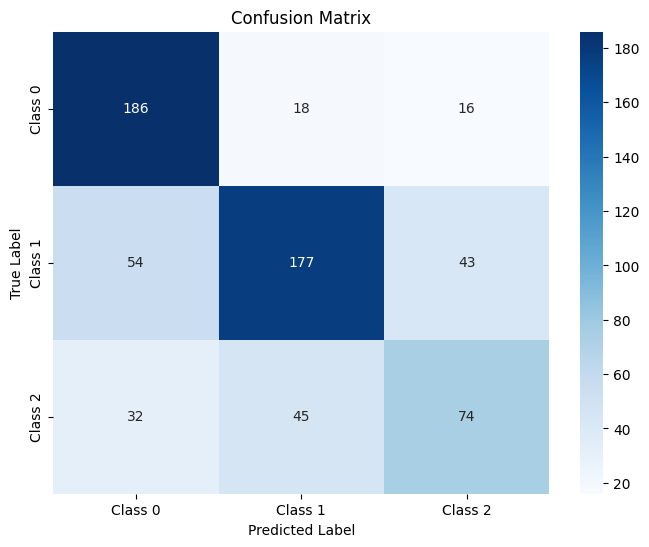

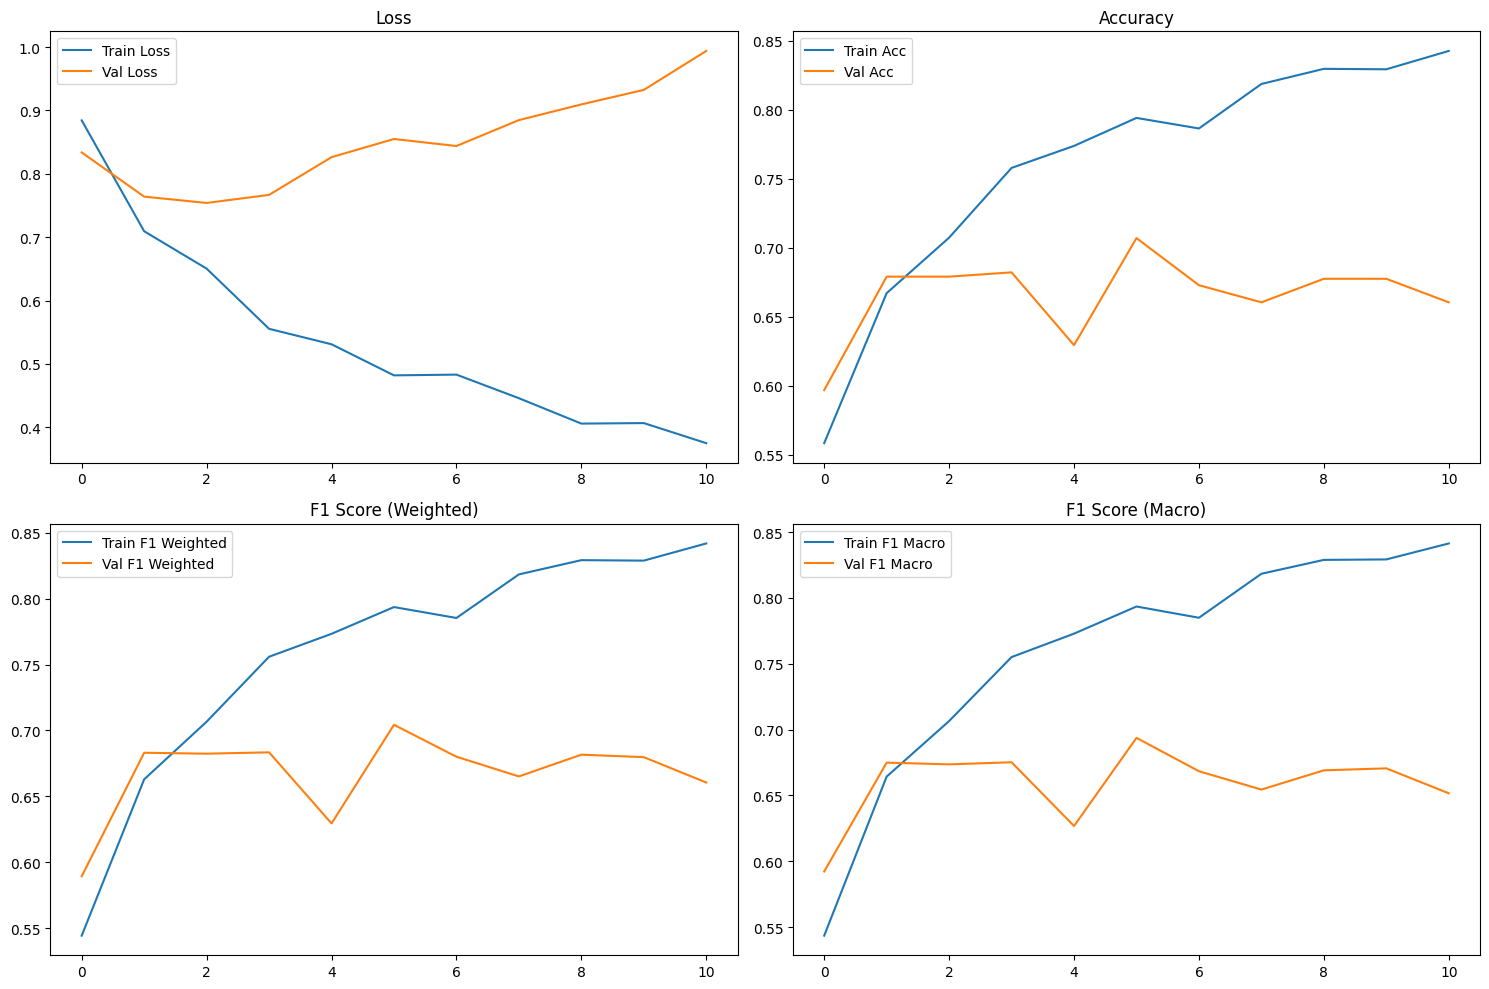


Final Results:
Best Validation F1: 0.7043
Test Accuracy: 0.6775
Test F1 (Weighted): 0.6725
Test F1 (Macro): 0.6553


In [ ]:
# Run training
if __name__ == "__main__":
    best_val_f1, test_metrics = run_training()
    print(f"\nFinal Results:")
    print(f"Best Validation F1: {best_val_f1:.4f}")
    print(f"Test Accuracy: {test_metrics['accuracy']:.4f}")
    print(f"Test F1 (Weighted): {test_metrics['f1_weighted']:.4f}")
    print(f"Test F1 (Macro): {test_metrics['f1_macro']:.4f}")

Class distribution:
label
0    1464
1    1830
2    1006
Name: count, dtype: int64
Adjusted class weights: {0: 0.9894709815427224, 1: 0.8850097505971868, 2: 1.193643424804851}
Train: 3225, Val: 430, Test: 645
Starting Improved Multimodal Training with XLM-RoBERTa
Loading models...


100%|███████████████████████████████████████| 338M/338M [00:10<00:00, 34.3MiB/s]


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

2025-06-22 19:20:58.314352: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750620058.588877     132 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750620058.668558     132 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

/tmp/ipykernel_132/1853269335.py:523: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Starting training...

Epoch 1/15


Training:  17%|█▋        | 140/807 [00:29<02:14,  4.97it/s, loss=0.1874]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  60%|██████    | 485/807 [01:38<01:04,  4.96it/s, loss=0.1265]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Evaluating: 100%|██████████| 54/54 [00:05<00:00,  9.13it/s]


Train - Loss: 0.1607, Acc: 0.4550, F1: 0.4543
Val   - Loss: 0.0971, Acc: 0.6605, F1: 0.6531
Per-class F1: [0.74021352 0.68126521 0.47619048]
New best validation F1: 0.6531

Epoch 2/15


Training:  33%|███▎      | 269/807 [00:54<01:48,  4.97it/s, loss=0.0552]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  67%|██████▋   | 538/807 [01:48<00:54,  4.95it/s, loss=0.0500]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Evaluating: 100%|██████████| 54/54 [00:06<00:00,  8.80it/s]


Train - Loss: 0.0882, Acc: 0.6695, F1: 0.6697
Val   - Loss: 0.0927, Acc: 0.6791, F1: 0.6756
Per-class F1: [0.72       0.71144279 0.54644809]
New best validation F1: 0.6756

Epoch 3/15


Training:   9%|▉         | 73/807 [00:15<02:27,  4.97it/s, loss=0.0792]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Evaluating: 100%|██████████| 54/54 [00:05<00:00,  9.42it/s]


Train - Loss: 0.0666, Acc: 0.7874, F1: 0.7883
Val   - Loss: 0.1074, Acc: 0.6605, F1: 0.6560
Per-class F1: [0.71720117 0.65634675 0.56701031]

Epoch 4/15


Training:   0%|          | 2/807 [00:00<04:33,  2.94it/s, loss=0.0436]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Evaluating: 100%|██████████| 54/54 [00:05<00:00,  9.98it/s]


Train - Loss: 0.0487, Acc: 0.8626, F1: 0.8630
Val   - Loss: 0.1302, Acc: 0.6698, F1: 0.6684
Per-class F1: [0.71186441 0.68817204 0.56994819]

Epoch 5/15


Training:   9%|▉         | 75/807 [00:15<02:26,  4.99it/s, loss=0.0237]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  12%|█▏        | 98/807 [00:19<02:22,  4.99it/s, loss=0.0464]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Evaluating: 100%|██████████| 54/54 [00:05<00:00,  9.68it/s]


Train - Loss: 0.0344, Acc: 0.9220, F1: 0.9220
Val   - Loss: 0.1385, Acc: 0.6698, F1: 0.6704
Per-class F1: [0.73454545 0.70496084 0.51485149]

Epoch 6/15


Evaluating: 100%|██████████| 54/54 [00:05<00:00,  9.82it/s]


Train - Loss: 0.0263, Acc: 0.9518, F1: 0.9518
Val   - Loss: 0.1687, Acc: 0.6651, F1: 0.6577
Per-class F1: [0.71148459 0.67267267 0.55294118]

Epoch 7/15


Evaluating: 100%|██████████| 54/54 [00:05<00:00,  9.97it/s]


Train - Loss: 0.0214, Acc: 0.9681, F1: 0.9681
Val   - Loss: 0.1644, Acc: 0.6512, F1: 0.6490
Per-class F1: [0.69158879 0.6685879  0.55208333]

Epoch 8/15


Training:  19%|█▉        | 153/807 [00:31<02:11,  4.99it/s, loss=0.0114]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  29%|██▉       | 238/807 [00:48<01:54,  4.98it/s, loss=0.0365]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Evaluating: 100%|██████████| 54/54 [00:05<00:00,  9.77it/s]


Train - Loss: 0.0180, Acc: 0.9808, F1: 0.9808
Val   - Loss: 0.1572, Acc: 0.6977, F1: 0.6881
Per-class F1: [0.74098361 0.73096447 0.53416149]
New best validation F1: 0.6881

Epoch 9/15


Training:  24%|██▎       | 191/807 [00:38<02:03,  5.00it/s, loss=0.0121]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  30%|███       | 244/807 [00:49<01:52,  5.02it/s, loss=0.0153]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Evaluating: 100%|██████████| 54/54 [00:05<00:00,  9.40it/s]


Train - Loss: 0.0161, Acc: 0.9843, F1: 0.9843
Val   - Loss: 0.1575, Acc: 0.6674, F1: 0.6675
Per-class F1: [0.7114094  0.68156425 0.57843137]

Epoch 10/15


Training:  32%|███▏      | 256/807 [00:51<01:50,  4.97it/s, loss=0.0120]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Evaluating: 100%|██████████| 54/54 [00:05<00:00,  9.48it/s]


Train - Loss: 0.0139, Acc: 0.9905, F1: 0.9905
Val   - Loss: 0.1544, Acc: 0.7023, F1: 0.6975
Per-class F1: [0.74285714 0.72826087 0.57627119]
New best validation F1: 0.6975

Epoch 11/15


Training:   3%|▎         | 21/807 [00:04<02:38,  4.95it/s, loss=0.0138]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  10%|█         | 83/807 [00:17<02:26,  4.96it/s, loss=0.0116]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Evaluating: 100%|██████████| 54/54 [00:09<00:00,  5.92it/s]


Train - Loss: 0.0134, Acc: 0.9935, F1: 0.9935
Val   - Loss: 0.1644, Acc: 0.6953, F1: 0.6880
Per-class F1: [0.72789116 0.73366834 0.54761905]

Epoch 12/15


Training:  11%|█         | 87/807 [00:17<02:25,  4.96it/s, loss=0.0108]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  53%|█████▎    | 430/807 [01:26<01:15,  5.00it/s, loss=0.0109]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Evaluating: 100%|██████████| 54/54 [00:05<00:00,  9.44it/s]


Train - Loss: 0.0133, Acc: 0.9938, F1: 0.9938
Val   - Loss: 0.1597, Acc: 0.7070, F1: 0.7009
Per-class F1: [0.73539519 0.74936709 0.56321839]
New best validation F1: 0.7009

Epoch 13/15


Training:  63%|██████▎   | 506/807 [01:41<01:00,  4.98it/s, loss=0.0111]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Evaluating: 100%|██████████| 54/54 [00:05<00:00,  9.75it/s]


Train - Loss: 0.0129, Acc: 0.9946, F1: 0.9946
Val   - Loss: 0.1636, Acc: 0.6953, F1: 0.6887
Per-class F1: [0.7260274  0.73737374 0.54651163]

Epoch 14/15


Training:   7%|▋         | 59/807 [00:12<02:30,  4.99it/s, loss=0.0117]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Evaluating: 100%|██████████| 54/54 [00:05<00:00,  9.81it/s]


Train - Loss: 0.0123, Acc: 0.9953, F1: 0.9953
Val   - Loss: 0.1650, Acc: 0.6977, F1: 0.6929
Per-class F1: [0.73333333 0.73298429 0.56179775]

Epoch 15/15


Training:   8%|▊         | 63/807 [00:12<02:28,  5.00it/s, loss=0.0109]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Evaluating: 100%|██████████| 54/54 [00:05<00:00, 10.02it/s]


Train - Loss: 0.0123, Acc: 0.9953, F1: 0.9953
Val   - Loss: 0.1653, Acc: 0.6977, F1: 0.6922
Per-class F1: [0.72727273 0.7371134  0.56      ]

FINAL EVALUATION ON TEST SET


Evaluating: 100%|██████████| 81/81 [00:08<00:00,  9.81it/s]



Test Results:
Test Loss: 0.1634
Test Accuracy: 0.7054
Test F1 (Weighted): 0.7016
Test F1 (Macro): 0.6898
Per-class F1: [0.73972603 0.72268908 0.60700389]

Detailed Classification Report:
              precision    recall  f1-score   support

     Class 0     0.7431    0.7364    0.7397       220
     Class 1     0.6719    0.7818    0.7227       275
     Class 2     0.7290    0.5200    0.6070       150

    accuracy                         0.7054       645
   macro avg     0.7147    0.6794    0.6898       645
weighted avg     0.7095    0.7054    0.7016       645



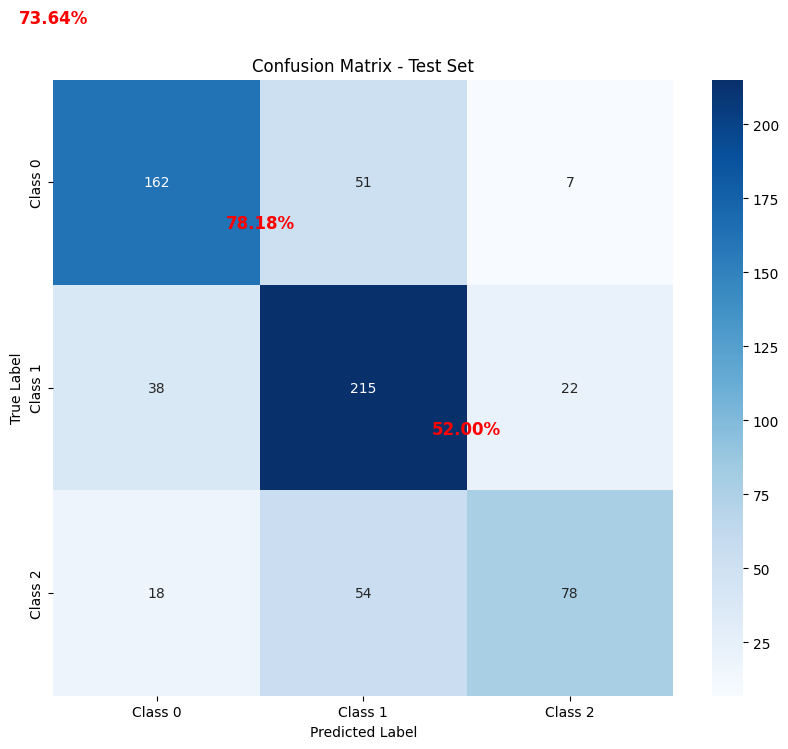

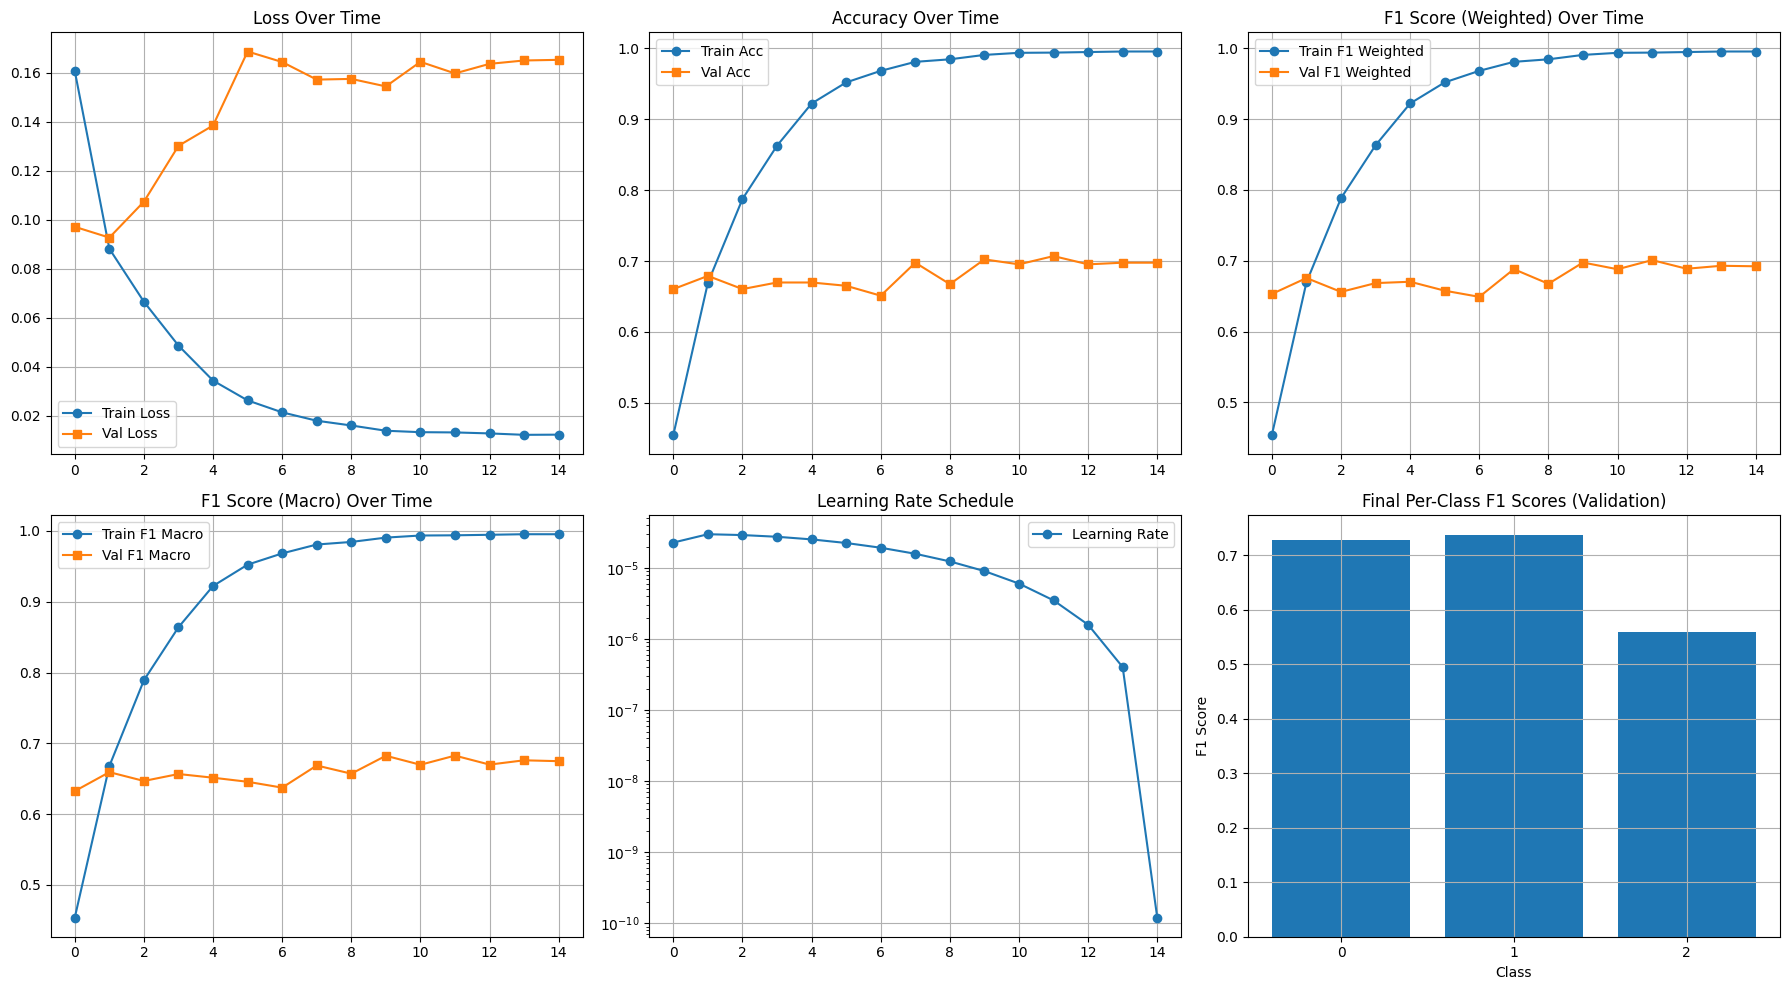


FINAL SUMMARY
Best Validation F1 (Weighted): 0.7009
Final Test Accuracy: 0.7054
Final Test F1 (Weighted): 0.7016
Final Test F1 (Macro): 0.6898
Per-class Test F1: [0.73972603 0.72268908 0.60700389]


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import clip
from PIL import Image
import random
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from torch.cuda import amp
from tqdm import tqdm
from collections import defaultdict
import gc
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModel
import cv2

def set_random_seed(random_seed):
    random.seed(random_seed)
    np.random.seed(random_seed)
    os.environ["PYTHONHASHSEED"] = str(random_seed)
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)
    torch.backends.cudnn.deterministic = True

class Config:
    NUM_EPOCHS = 15
    BATCH_SIZE = 8  # Smaller batch size for better generalization
    CLIP_MODEL = "ViT-B/32"  # Using smaller CLIP model for stability
    TEXT_MODEL = "xlm-roberta-base"  # XLM-RoBERTa for multilingual text
    LR = 3e-5
    CLIP_LR = 1e-6  # Much lower learning rate for CLIP
    DROPOUT = 0.3
    NUM_CLASSES = 3
    SEED = 42
    MAX_LEN = 128
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    LSTM_HIDDEN = 256
    FC_HIDDEN = 512
    FOCAL_ALPHA = 0.25
    FOCAL_GAMMA = 2.0
    LABEL_SMOOTHING = 0.1

config = Config()

# Load data
df = pd.read_csv("/kaggle/input/meme-ds/changed_ds/dataset_with_class.csv")
df.columns = ['image_name', 'Text', 'label']

# Encode labels
le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])

print("Class distribution:")
class_counts = df['label'].value_counts().sort_index()
print(class_counts)

# Calculate class weights with stronger balancing
class_weights = compute_class_weight('balanced', classes=np.unique(df['label']), y=df['label'])
# Apply square root to make weights less extreme
class_weights = np.sqrt(class_weights)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}
print(f"Adjusted class weights: {class_weights_dict}")

# Data splits with more data for training
X = df[['image_name', 'Text']].values
y = df['label'].values

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.6, stratify=y_temp, random_state=42
)

train_df = pd.DataFrame(X_train, columns=['image_name', 'Text'])
train_df['label'] = y_train

val_df = pd.DataFrame(X_val, columns=['image_name', 'Text'])
val_df['label'] = y_val

test_df = pd.DataFrame(X_test, columns=['image_name', 'Text'])
test_df['label'] = y_test

print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, class_weights=None, label_smoothing=0.0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.class_weights = class_weights
        self.label_smoothing = label_smoothing

    def forward(self, inputs, targets):
        # Apply label smoothing
        if self.label_smoothing > 0:
            n_classes = inputs.size(1)
            smooth_targets = torch.zeros_like(inputs)
            smooth_targets.fill_(self.label_smoothing / (n_classes - 1))
            smooth_targets.scatter_(1, targets.unsqueeze(1), 1 - self.label_smoothing)
            ce_loss = -torch.sum(smooth_targets * F.log_softmax(inputs, dim=1), dim=1)
        else:
            ce_loss = F.cross_entropy(inputs, targets, weight=self.class_weights, reduction='none')

        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean()

class ImprovedMultimodalDataset(Dataset):
    def __init__(self, df, tokenizer, clip_preprocess, is_train=True):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.clip_preprocess = clip_preprocess
        self.is_train = is_train
        self.labels = torch.tensor(df['label'].values, dtype=torch.long)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # Load and preprocess image with error handling
        image_path = f"/kaggle/input/meme-ds/changed_ds/img/{row['image_name']}"
        try:
            image = Image.open(image_path)
            if image.mode == 'RGBA':
                # Convert RGBA to RGB
                background = Image.new('RGB', image.size, (255, 255, 255))
                background.paste(image, mask=image.split()[-1])
                image = background
            elif image.mode != 'RGB':
                image = image.convert('RGB')

            image_input = self.clip_preprocess(image)
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            # Create a white dummy image
            image_input = torch.ones((3, 224, 224))

        # Process text with XLM-RoBERTa
        text = str(row['Text']).strip()
        if not text:
            text = "[EMPTY]"

        text_encoding = self.tokenizer(
            text,
            max_length=config.MAX_LEN,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        label = self.labels[idx]

        return {
            'image': image_input,
            'input_ids': text_encoding['input_ids'].squeeze(0),
            'attention_mask': text_encoding['attention_mask'].squeeze(0),
            'label': label
        }

class AttentionFusion(nn.Module):
    def __init__(self, text_dim, image_dim, hidden_dim):
        super(AttentionFusion, self).__init__()
        self.text_proj = nn.Linear(text_dim, hidden_dim)
        self.image_proj = nn.Linear(image_dim, hidden_dim)
        self.attention = nn.MultiheadAttention(hidden_dim, num_heads=8, dropout=0.1)
        self.norm = nn.LayerNorm(hidden_dim)

    def forward(self, text_feat, image_feat):
        # Project to same dimension
        text_proj = self.text_proj(text_feat)  # [batch, hidden_dim]
        image_proj = self.image_proj(image_feat)  # [batch, hidden_dim]

        # Prepare for attention (seq_len=2, batch, hidden_dim)
        features = torch.stack([text_proj, image_proj], dim=0)  # [2, batch, hidden_dim]

        # Self-attention
        attended, _ = self.attention(features, features, features)

        # Average pooling and residual connection
        fused = attended.mean(dim=0)  # [batch, hidden_dim]
        fused = self.norm(fused + text_proj + image_proj)

        return fused

class ImprovedMultimodalModel(nn.Module):
    def __init__(self, clip_model, text_model, num_classes):
        super(ImprovedMultimodalModel, self).__init__()

        # CLIP for images (frozen backbone)
        self.clip_model = clip_model
        for param in self.clip_model.parameters():
            param.requires_grad = False

        # XLM-RoBERTa for text
        self.text_model = text_model

        # Get dimensions
        self.image_dim = 512  # CLIP ViT-B/32 output dimension
        self.text_dim = self.text_model.config.hidden_size  # XLM-RoBERTa hidden size

        # Text processing with LSTM
        self.text_lstm = nn.LSTM(
            input_size=self.text_dim,
            hidden_size=config.LSTM_HIDDEN,
            num_layers=2,
            batch_first=True,
            dropout=0.2,
            bidirectional=True
        )

        # Image processing
        self.image_fc = nn.Sequential(
            nn.Linear(self.image_dim, config.FC_HIDDEN),
            nn.ReLU(),
            nn.Dropout(config.DROPOUT),
            nn.Linear(config.FC_HIDDEN, config.FC_HIDDEN)
        )

        # Attention-based fusion
        self.fusion = AttentionFusion(
            text_dim=config.LSTM_HIDDEN * 2,  # Bidirectional LSTM
            image_dim=config.FC_HIDDEN,
            hidden_dim=config.FC_HIDDEN
        )

        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(config.FC_HIDDEN, config.FC_HIDDEN // 2),
            nn.ReLU(),
            nn.Dropout(config.DROPOUT),
            nn.Linear(config.FC_HIDDEN // 2, num_classes)
        )

        # Initialize weights
        self._init_weights()

    def _init_weights(self):
        for module in [self.image_fc, self.classifier]:
            for m in module.modules():
                if isinstance(m, nn.Linear):
                    nn.init.xavier_uniform_(m.weight)
                    if m.bias is not None:
                        nn.init.zeros_(m.bias)

    def forward(self, image, input_ids, attention_mask):
        batch_size = image.shape[0]

        # Extract image features with CLIP (frozen)
        with torch.no_grad():
            image_features = self.clip_model.encode_image(image).float()

        # Process image features
        image_out = self.image_fc(image_features)

        # Extract text features with XLM-RoBERTa
        text_outputs = self.text_model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            output_hidden_states=True
        )

        # Use last hidden state for LSTM
        text_hidden = text_outputs.last_hidden_state  # [batch, seq_len, hidden_size]

        # Apply LSTM to text features
        lstm_out, (hidden, _) = self.text_lstm(text_hidden)

        # Use attention mask to get proper pooling
        mask_expanded = attention_mask.unsqueeze(-1).expand(lstm_out.size()).float()
        lstm_out = lstm_out * mask_expanded
        text_out = lstm_out.sum(1) / mask_expanded.sum(1).clamp(min=1)  # Masked average pooling

        # Attention-based fusion
        fused_features = self.fusion(text_out, image_out)

        # Classification
        output = self.classifier(fused_features)

        return output

def create_weighted_sampler(labels):
    """Create weighted sampler with more aggressive oversampling for minority classes"""
    class_counts = np.bincount(labels)
    # Use inverse of class frequency with power scaling
    class_weights = 1.0 / (class_counts ** 0.75)  # Less aggressive than 1.0/counts
    sample_weights = class_weights[labels]

    sampler = WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights) * 2,  # Oversample
        replacement=True
    )
    return sampler

def compute_metrics(y_true, y_pred):
    """Compute comprehensive metrics"""
    accuracy = accuracy_score(y_true, y_pred)
    f1_weighted = f1_score(y_true, y_pred, average='weighted')
    f1_macro = f1_score(y_true, y_pred, average='macro')
    f1_per_class = f1_score(y_true, y_pred, average=None)

    return {
        'accuracy': accuracy,
        'f1_weighted': f1_weighted,
        'f1_macro': f1_macro,
        'f1_per_class': f1_per_class
    }

class ImprovedEngine:
    def __init__(self, model, optimizer, criterion, scheduler=None):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.scheduler = scheduler

    def train_epoch(self, train_loader, scaler):
        self.model.train()
        total_loss = 0
        all_preds = []
        all_labels = []

        progress_bar = tqdm(train_loader, desc="Training")

        for batch in progress_bar:
            images = batch['image'].to(config.DEVICE)
            input_ids = batch['input_ids'].to(config.DEVICE)
            attention_mask = batch['attention_mask'].to(config.DEVICE)
            labels = batch['label'].to(config.DEVICE)

            self.optimizer.zero_grad()

            with torch.amp.autocast('cuda'):
                outputs = self.model(images, input_ids, attention_mask)
                loss = self.criterion(outputs, labels)

            scaler.scale(loss).backward()
            # Gradient clipping
            scaler.unscale_(self.optimizer)
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)

            scaler.step(self.optimizer)
            scaler.update()

            if self.scheduler:
                self.scheduler.step()

            total_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})

        avg_loss = total_loss / len(train_loader)
        metrics = compute_metrics(all_labels, all_preds)

        return avg_loss, metrics

    def evaluate(self, eval_loader):
        self.model.eval()
        total_loss = 0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for batch in tqdm(eval_loader, desc="Evaluating"):
                images = batch['image'].to(config.DEVICE)
                input_ids = batch['input_ids'].to(config.DEVICE)
                attention_mask = batch['attention_mask'].to(config.DEVICE)
                labels = batch['label'].to(config.DEVICE)

                outputs = self.model(images, input_ids, attention_mask)
                loss = self.criterion(outputs, labels)

                total_loss += loss.item()

                preds = torch.argmax(outputs, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        avg_loss = total_loss / len(eval_loader)
        metrics = compute_metrics(all_labels, all_preds)

        return avg_loss, metrics, all_preds, all_labels

def plot_training_history(history):
    """Plot comprehensive training history"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))

    # Loss
    axes[0, 0].plot(history['train_loss'], label='Train Loss', marker='o')
    axes[0, 0].plot(history['val_loss'], label='Val Loss', marker='s')
    axes[0, 0].set_title('Loss Over Time')
    axes[0, 0].legend()
    axes[0, 0].grid(True)

    # Accuracy
    axes[0, 1].plot(history['train_acc'], label='Train Acc', marker='o')
    axes[0, 1].plot(history['val_acc'], label='Val Acc', marker='s')
    axes[0, 1].set_title('Accuracy Over Time')
    axes[0, 1].legend()
    axes[0, 1].grid(True)

    # F1 Weighted
    axes[0, 2].plot(history['train_f1_weighted'], label='Train F1 Weighted', marker='o')
    axes[0, 2].plot(history['val_f1_weighted'], label='Val F1 Weighted', marker='s')
    axes[0, 2].set_title('F1 Score (Weighted) Over Time')
    axes[0, 2].legend()
    axes[0, 2].grid(True)

    # F1 Macro
    axes[1, 0].plot(history['train_f1_macro'], label='Train F1 Macro', marker='o')
    axes[1, 0].plot(history['val_f1_macro'], label='Val F1 Macro', marker='s')
    axes[1, 0].set_title('F1 Score (Macro) Over Time')
    axes[1, 0].legend()
    axes[1, 0].grid(True)

    # Learning Rate
    if 'lr' in history:
        axes[1, 1].plot(history['lr'], label='Learning Rate', marker='o')
        axes[1, 1].set_title('Learning Rate Schedule')
        axes[1, 1].legend()
        axes[1, 1].grid(True)
        axes[1, 1].set_yscale('log')

    # Per-class F1 scores (final epoch)
    if 'val_f1_per_class' in history and len(history['val_f1_per_class']) > 0:
        final_f1_per_class = history['val_f1_per_class'][-1]
        axes[1, 2].bar(range(len(final_f1_per_class)), final_f1_per_class)
        axes[1, 2].set_title('Final Per-Class F1 Scores (Validation)')
        axes[1, 2].set_xlabel('Class')
        axes[1, 2].set_ylabel('F1 Score')
        axes[1, 2].set_xticks(range(len(final_f1_per_class)))
        axes[1, 2].grid(True)

    plt.tight_layout()
    plt.show()

def run_training():
    set_random_seed(config.SEED)

    # Load models
    print("Loading models...")
    clip_model, clip_preprocess = clip.load(config.CLIP_MODEL, device=config.DEVICE)
    tokenizer = AutoTokenizer.from_pretrained(config.TEXT_MODEL)
    text_model = AutoModel.from_pretrained(config.TEXT_MODEL)

    # Create datasets
    train_dataset = ImprovedMultimodalDataset(train_df, tokenizer, clip_preprocess, is_train=True)
    val_dataset = ImprovedMultimodalDataset(val_df, tokenizer, clip_preprocess, is_train=False)
    test_dataset = ImprovedMultimodalDataset(test_df, tokenizer, clip_preprocess, is_train=False)

    # Create weighted sampler
    train_sampler = create_weighted_sampler(train_df['label'].values)

    # Create data loaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=config.BATCH_SIZE,
        sampler=train_sampler,
        num_workers=2,
        pin_memory=True
    )
    val_loader = DataLoader(val_dataset, batch_size=config.BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=config.BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

    # Create model
    model = ImprovedMultimodalModel(
        clip_model=clip_model,
        text_model=text_model,
        num_classes=config.NUM_CLASSES
    ).to(config.DEVICE)

    # Create optimizers with different learning rates
    clip_params = []
    text_params = list(model.text_model.parameters())
    other_params = []

    for name, param in model.named_parameters():
        if 'clip_model' in name:
            clip_params.append(param)
        elif 'text_model' not in name:
            other_params.append(param)

    optimizer = torch.optim.AdamW([
        {'params': text_params, 'lr': config.LR},
        {'params': other_params, 'lr': config.LR},
        {'params': clip_params, 'lr': config.CLIP_LR}
    ], weight_decay=0.01)

    # Focal loss with class weights
    criterion = FocalLoss(
        alpha=config.FOCAL_ALPHA,
        gamma=config.FOCAL_GAMMA,
        class_weights=torch.FloatTensor(list(class_weights_dict.values())).to(config.DEVICE),
        label_smoothing=config.LABEL_SMOOTHING
    )

    # Scheduler
    num_training_steps = config.NUM_EPOCHS * len(train_loader)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=[config.LR, config.LR, config.CLIP_LR],
        total_steps=num_training_steps,
        pct_start=0.1,
        anneal_strategy='cos'
    )

    # Create engine
    engine = ImprovedEngine(model, optimizer, criterion, scheduler)
    scaler = torch.cuda.amp.GradScaler()

    # Training loop with improved early stopping
    history = defaultdict(list)
    best_val_f1 = 0.0
    patience = 7
    patience_counter = 0
    min_delta = 0.001

    print("Starting training...")
    for epoch in range(config.NUM_EPOCHS):
        print(f"\nEpoch {epoch + 1}/{config.NUM_EPOCHS}")

        # Train
        train_loss, train_metrics = engine.train_epoch(train_loader, scaler)

        # Validate
        val_loss, val_metrics, _, _ = engine.evaluate(val_loader)

        # Log metrics
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_metrics['accuracy'])
        history['val_acc'].append(val_metrics['accuracy'])
        history['train_f1_weighted'].append(train_metrics['f1_weighted'])
        history['val_f1_weighted'].append(val_metrics['f1_weighted'])
        history['train_f1_macro'].append(train_metrics['f1_macro'])
        history['val_f1_macro'].append(val_metrics['f1_macro'])
        history['val_f1_per_class'].append(val_metrics['f1_per_class'])
        history['lr'].append(scheduler.get_last_lr()[0])

        print(f"Train - Loss: {train_loss:.4f}, Acc: {train_metrics['accuracy']:.4f}, F1: {train_metrics['f1_weighted']:.4f}")
        print(f"Val   - Loss: {val_loss:.4f}, Acc: {val_metrics['accuracy']:.4f}, F1: {val_metrics['f1_weighted']:.4f}")
        print(f"Per-class F1: {val_metrics['f1_per_class']}")

        # Early stopping with minimum improvement
        if val_metrics['f1_weighted'] > best_val_f1 + min_delta:
            best_val_f1 = val_metrics['f1_weighted']
            torch.save(model.state_dict(), 'best_improved_multimodal_model.pth')
            patience_counter = 0
            print(f"New best validation F1: {best_val_f1:.4f}")
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch + 1}")
            break

    # Load best model for testing
    model.load_state_dict(torch.load('best_improved_multimodal_model.pth'))

    # Test evaluation
    print("\n" + "="*50)
    print("FINAL EVALUATION ON TEST SET")
    print("="*50)

    test_loss, test_metrics, test_preds, test_labels = engine.evaluate(test_loader)

    print(f"\nTest Results:")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_metrics['accuracy']:.4f}")
    print(f"Test F1 (Weighted): {test_metrics['f1_weighted']:.4f}")
    print(f"Test F1 (Macro): {test_metrics['f1_macro']:.4f}")
    print(f"Per-class F1: {test_metrics['f1_per_class']}")

    # Detailed classification report
    print("\nDetailed Classification Report:")
    print(classification_report(
        test_labels, test_preds,
        target_names=[f'Class {i}' for i in range(config.NUM_CLASSES)],
        digits=4
    ))

    # Plot confusion matrix
    cm = confusion_matrix(test_labels, test_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=[f'Class {i}' for i in range(config.NUM_CLASSES)],
                yticklabels=[f'Class {i}' for i in range(config.NUM_CLASSES)])
    plt.title('Confusion Matrix - Test Set')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    # Add per-class accuracy to the plot
    per_class_acc = cm.diagonal() / cm.sum(axis=1)
    for i, acc in enumerate(per_class_acc):
        plt.text(i, i-0.3, f'{acc:.2%}', ha='center', va='center',
                color='red', fontweight='bold', fontsize=12)

    plt.show()

    # Plot training history
    plot_training_history(history)

    # Cleanup
    del model, clip_model, text_model
    gc.collect()
    torch.cuda.empty_cache()

    return best_val_f1, test_metrics

# Run training
if __name__ == "__main__":
    print("Starting Improved Multimodal Training with XLM-RoBERTa")
    print("="*60)
    best_val_f1, test_metrics = run_training()

    print(f"\n" + "="*60)
    print("FINAL SUMMARY")
    print("="*60)
    print(f"Best Validation F1 (Weighted): {best_val_f1:.4f}")
    print(f"Final Test Accuracy: {test_metrics['accuracy']:.4f}")
    print(f"Final Test F1 (Weighted): {test_metrics['f1_weighted']:.4f}")
    print(f"Final Test F1 (Macro): {test_metrics['f1_macro']:.4f}")
    print(f"Per-class Test F1: {test_metrics['f1_per_class']}")